<a href="https://www.kaggle.com/code/adelinmil/cmi-eda-chunked-ds-memory-reduction?scriptVersionId=145674135" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## 0-Imports

In [1]:
!pip install nb_black==1.0.5 --quiet

%load_ext lab_black

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 2.34.4 requires packaging<22.0dev,>=14.3, but you have packaging 23.2 which is incompatible.
jupyterlab-lsp 4.2.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.11.2 which is incompatible.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.2 which is incompatible.


In [2]:
import numpy as np
import pandas as pd

pd.set_option("display.max_rows", None)

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

import random

from tqdm import tqdm
import os

import warnings

warnings.filterwarnings("ignore")

## 1-Fixing Problems With train_event (thorough EDA)

In [3]:
sleep_events = pd.read_csv(
    "/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv",
    dtype={"night": object},
)

In [4]:
sleep_events.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [5]:
sleep_events.describe(include=["O"])

,series_id,night,event,timestamp
count,14508,14508,14508,9585
unique,277,84,2,9360
top,78569a801a38,2,onset,2017-11-27T21:37:00-0500
freq,168,554,7254,3


In [6]:
sleep_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14508 non-null  object 
 1   night      14508 non-null  object 
 2   event      14508 non-null  object 
 3   step       9585 non-null   float64
 4   timestamp  9585 non-null   object 
dtypes: float64(1), object(4)
memory usage: 566.8+ KB


In [7]:
pd.DataFrame(
    {
        "# of null values": sleep_events.isna().sum(),
        "% of null values": sleep_events.isna().sum() / len(sleep_events),
    }
).style.background_gradient(subset=["% of null values"])

,# of null values,% of null values
series_id,0,0.000000
night,0,0.000000
event,0,0.000000
step,4923,0.339330
timestamp,4923,0.339330


In [8]:
sleep_events.dropna(inplace=True)
sleep_events.isna().sum()

series_id    0
night        0
event        0
step         0
timestamp    0
dtype: int64

In [9]:
sleep_events.reset_index(drop=True, inplace=True)

In [10]:
sleep_events.night.value_counts()[(sleep_events.night.value_counts() % 2 != 0)]

night
7     417
10    397
20    331
17    331
30     75
Name: count, dtype: int64

In [11]:
fault_indecies = []

for idx in range(0, len(sleep_events) - 1):
    logic = (sleep_events.loc[idx, "night"] != sleep_events.loc[idx + 1, "night"]) and (
        sleep_events.loc[idx, "night"] != sleep_events.loc[idx - 1, "night"]
    )

    if logic:
        fault_indecies.append(idx)

fault_indecies  # NOTE: after dropping na  the index is reset

[310, 957, 2668, 9099, 9352]

In [12]:
# Example for fault index
sleep_events[sleep_events["night"] == "20"].groupby("series_id").get_group(
    "0ce74d6d2106"
)

,series_id,night,event,step,timestamp
310,0ce74d6d2106,20,onset,332376.0,2017-09-09T22:08:00-0400


In [13]:
sleep_events.drop(fault_indecies, axis=0, inplace=True)

In [14]:
sleep_events.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


## 2- Memory Reduction

In [15]:
ts = pd.read_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet')
ts.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


In [16]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:4] == 'uint':
                if c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)  
            else:
                # can't be smaller than that because of the parquet file format
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


ts = reduce_mem_usage(ts)

Memory usage of dataframe is 3416.54 MB
Memory usage after optimization is: 2547.12 MB
Decreased by 25.4%


In [17]:
series_ids = set(ts.series_id.unique()).intersection(sleep_events.series_id.unique())

## 3- Visualization Of One Series (03d92c9f6f8a)

In [18]:
group = ts[ts['series_id'] == '03d92c9f6f8a']
event = sleep_events[sleep_events['series_id'] == '03d92c9f6f8a']

In [19]:
group['timestamp'] = pd.to_datetime(group['timestamp']).apply(lambda t: t.tz_localize(None))
event['timestamp'] = pd.to_datetime(event['timestamp']).apply(lambda t: t.tz_localize(None))

In [20]:
combined = pd.merge(group, event, on=['series_id', 'timestamp'], how = 'outer')
    
combined['event'] = combined['event'].map({np.nan: 0, 'onset': -1, 'wakeup': 1})
combined.rename(columns = {'step_x': 'step'}, inplace = True)
combined.drop('step_y', axis = 1, inplace = True)

for index in combined[combined.event == 1].index:
    
    night_start = combined.timestamp.iloc[index] - timedelta(hours = 16)
    night_end = combined.timestamp.iloc[index] + timedelta(hours = 8)

    combined.loc[(night_start <= combined.timestamp) &  (combined.timestamp <= night_end), 'night'] = combined.night.loc[index] 

combined.dropna(axis = 0, inplace = True)

In [21]:
combined.reset_index(drop = True, inplace = True)
combined.head()

,series_id,step,timestamp,anglez,enmo,night,event
0,03d92c9f6f8a,2004,2018-05-31 14:47:00,-15.907700,0.1101,1,0
1,03d92c9f6f8a,2005,2018-05-31 14:47:05,-14.437500,0.0871,1,0
2,03d92c9f6f8a,2006,2018-05-31 14:47:10,-21.754601,0.0588,1,0
3,03d92c9f6f8a,2007,2018-05-31 14:47:15,-5.035000,0.3986,1,0
4,03d92c9f6f8a,2008,2018-05-31 14:47:20,-2.527300,0.0784,1,0


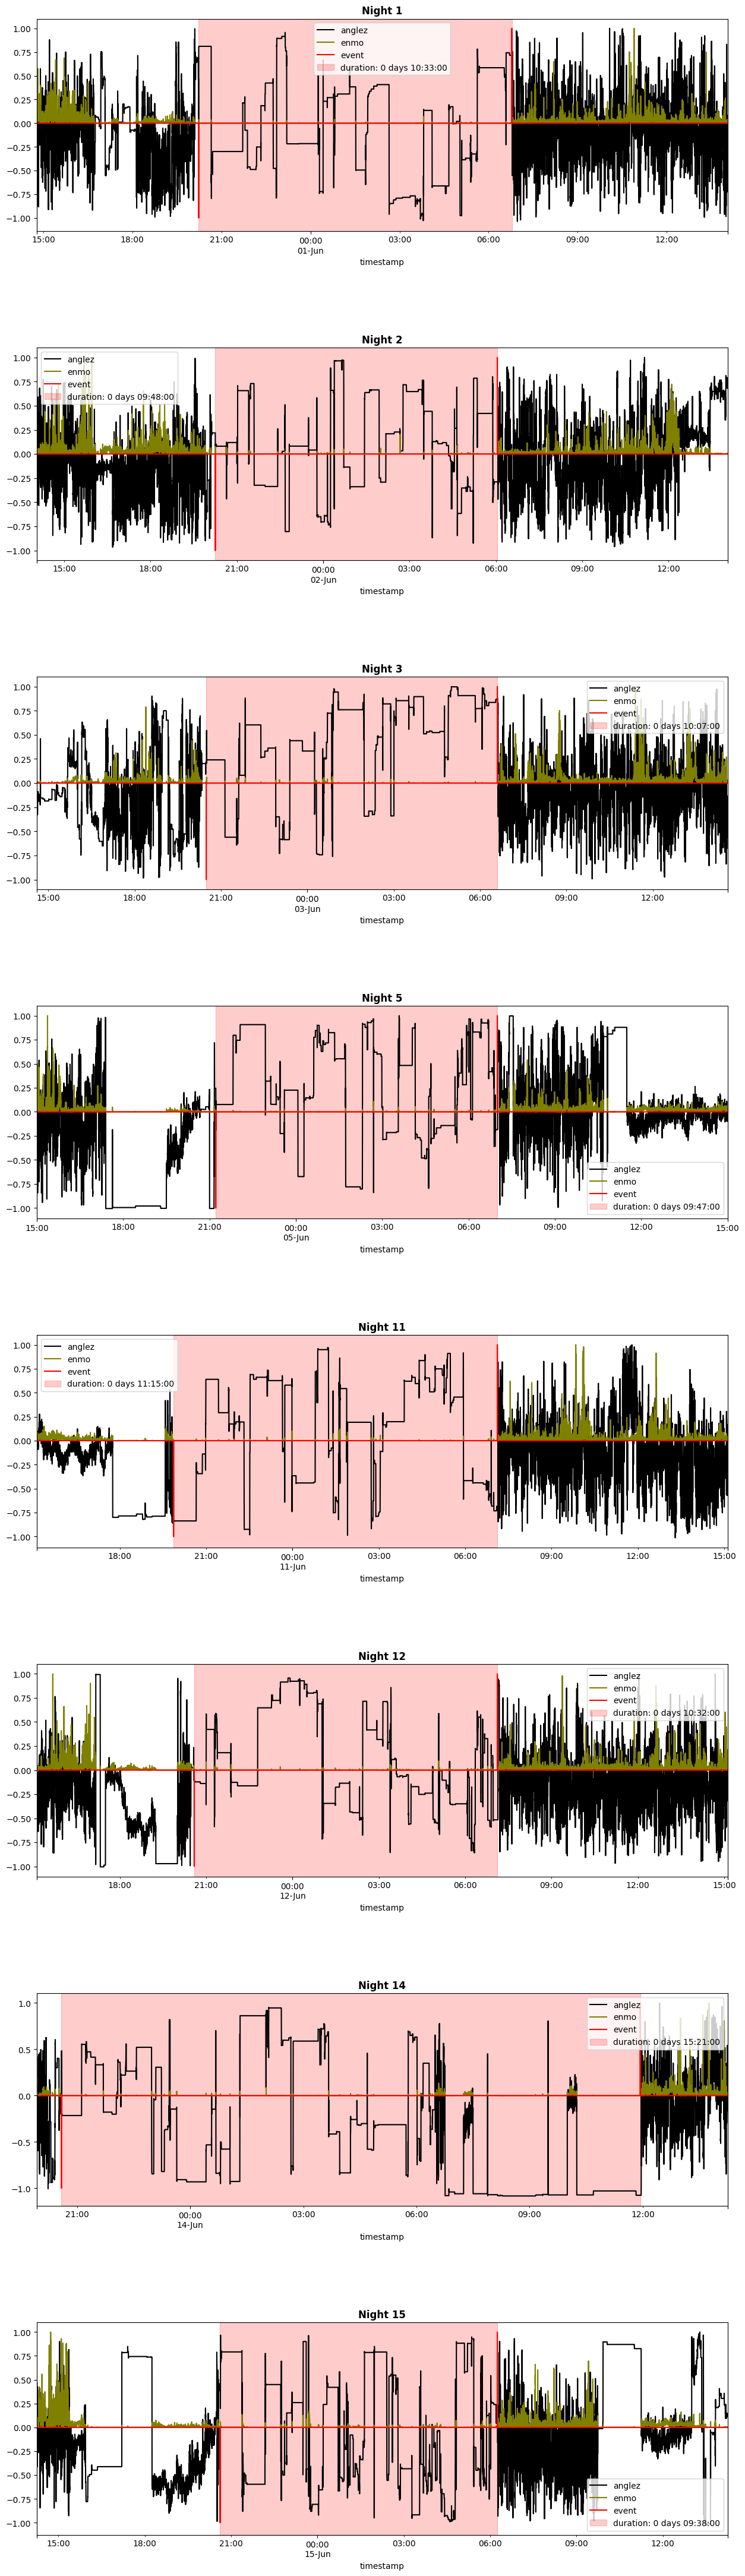

In [22]:
nights = event.night.unique()

f, axs = plt.subplots(nrows=len(nights), ncols=1)
f.set_figheight(55)
f.set_figwidth(15)

plt.subplots_adjust(
    hspace = 0.55
)

for idx, ax in enumerate(axs.ravel()):
    
    night = combined[combined.night == nights[idx]].set_index('timestamp')
    ax.set_title(f'Night {nights[idx]}', fontsize=12, weight = 'bold')
    
    (night.anglez / max(night.anglez)).plot(color = 'black', ax = ax) # noramlized
    (night.enmo / max(night.enmo)).plot(color = '#808000', ax = ax) # normalized
    night.event.plot(color = 'red', ax = ax)
    
    onset = night.query("event == 1").index.values[0]
    wakeup = night.query("event == -1").index.values[0]
    ax.axvspan(onset,
               wakeup,
               color = 'red',
               label = f'duration: {pd.to_timedelta(onset - wakeup)}',
               alpha=0.2)
    
    ax.legend()

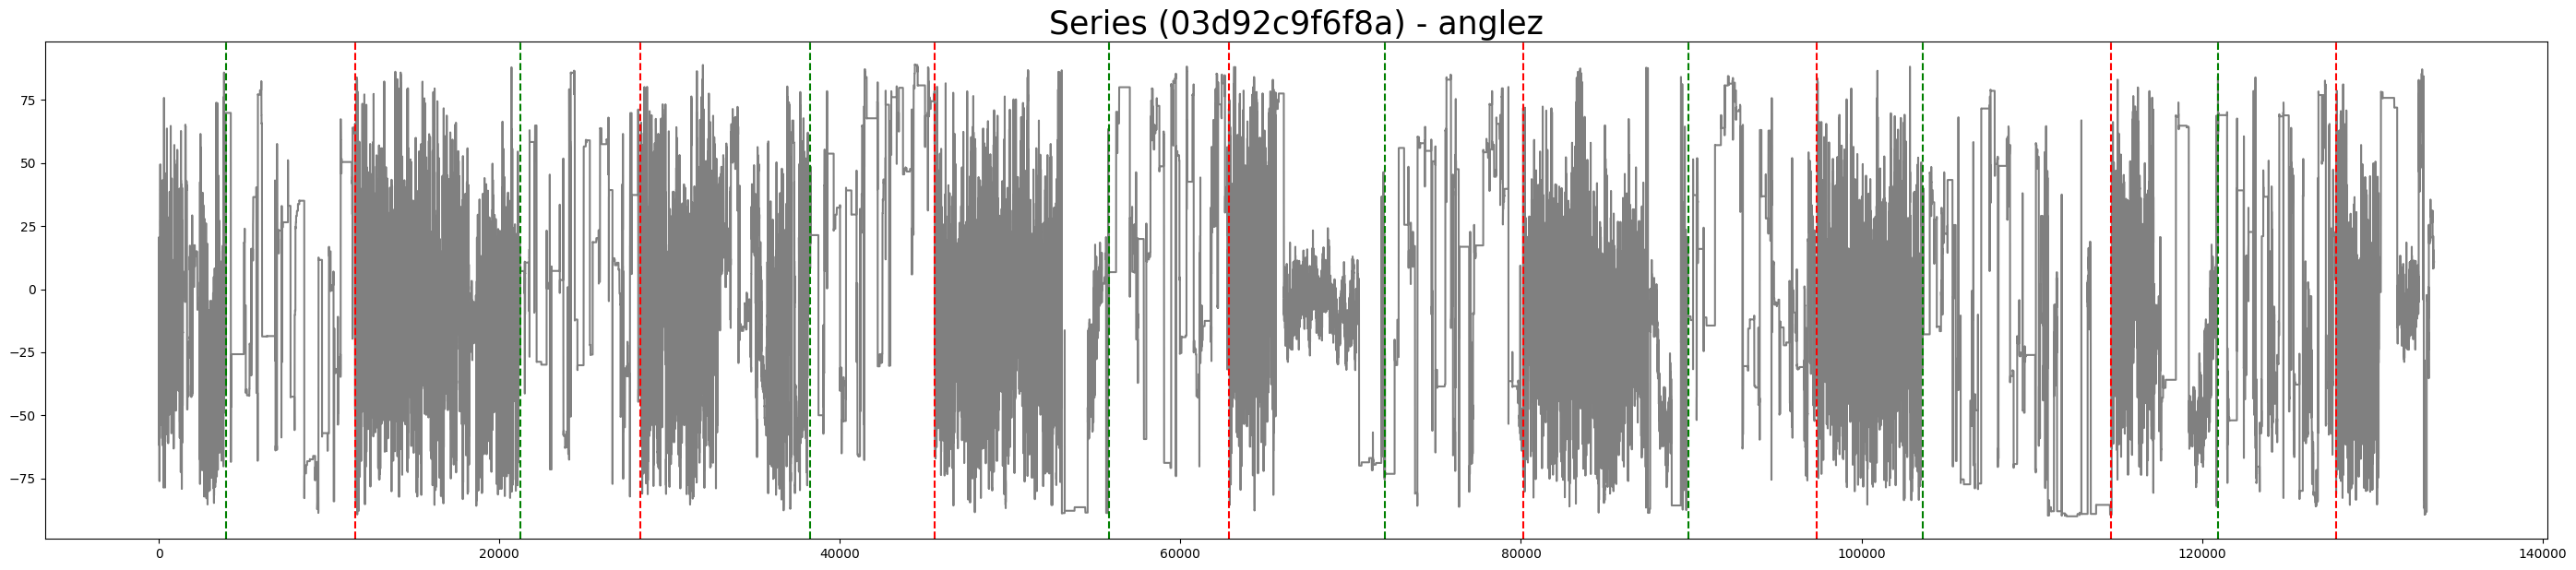

In [23]:
combined.anglez.plot(figsize = (35, 7), color = 'gray').set_title(f'Series (03d92c9f6f8a) - anglez', fontsize = 25)

for index in combined[combined['event'] == 1].index:
    plt.axvline(x =  index, color = 'r', linestyle = 'dashed')
    
for index in combined[combined['event'] == -1].index:
    plt.axvline(x =  index, color = 'g', linestyle = 'dashed')

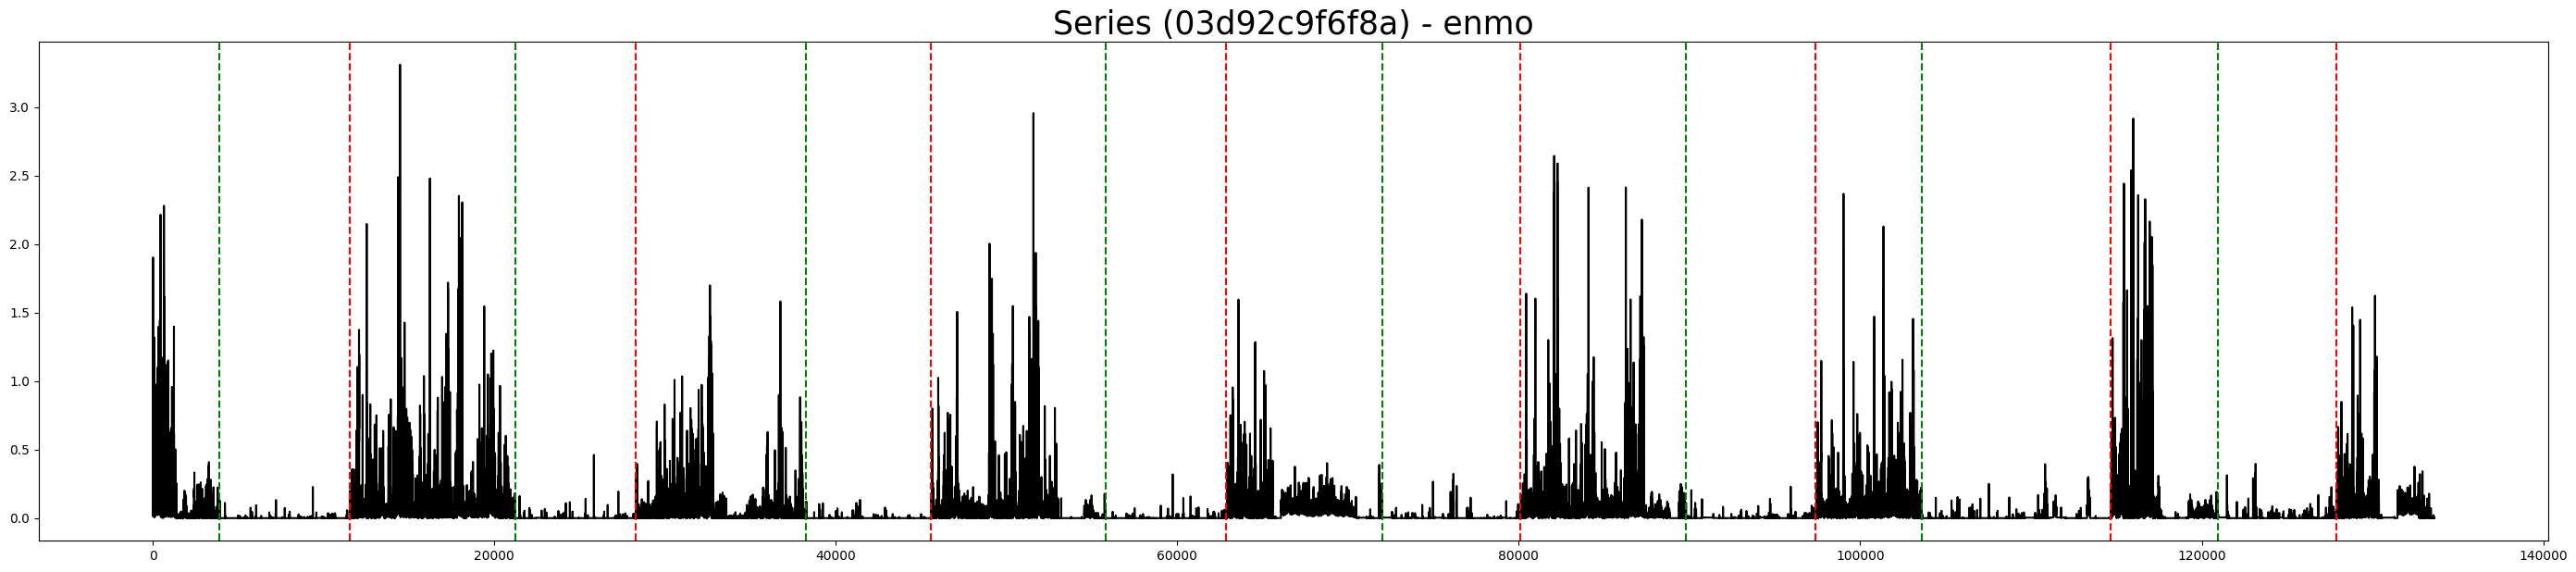

In [24]:
combined.enmo.plot(figsize = (35, 7), color = 'black').set_title(f'Series (03d92c9f6f8a) - enmo', fontsize = 25)

for index in combined[combined['event'] == 1].index:
    plt.axvline(x =  index, color = 'r', linestyle = 'dashed')
    
for index in combined[combined['event'] == -1].index:
    plt.axvline(x =  index, color = 'g', linestyle = 'dashed')

In [25]:
sleep_events['timestamp'] = pd.to_datetime(sleep_events['timestamp']).apply(lambda t: t.tz_localize(None))

Text(0.5, 1.0, 'distribution of sleep hour')

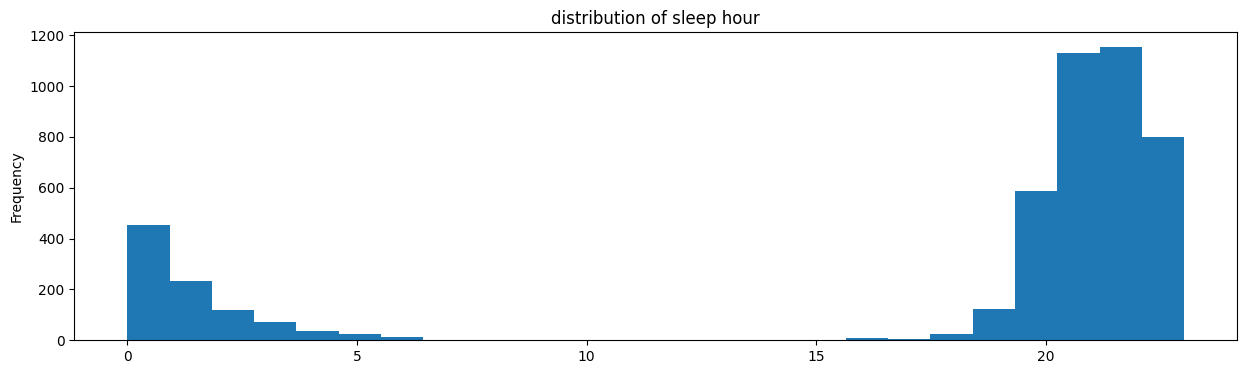

In [26]:
sleep_events[sleep_events.event =='onset'].timestamp.dt.hour.plot(kind = 'hist', figsize = (15, 4), bins = 25).set_title(f'distribution of sleep hour')

Text(0.5, 1.0, 'distribution of wakeup hour')

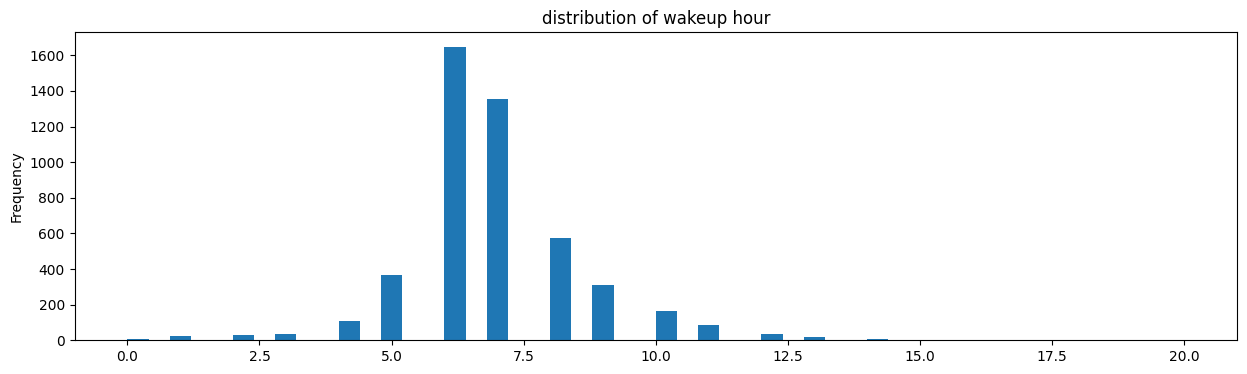

In [27]:
sleep_events[sleep_events.event == 'wakeup'].timestamp.dt.hour.plot(kind = 'hist', figsize = (15, 4), bins = 50).set_title(f'distribution of wakeup hour')

Text(0.5, 1.0, 'Sleep Duration BoxPlot')

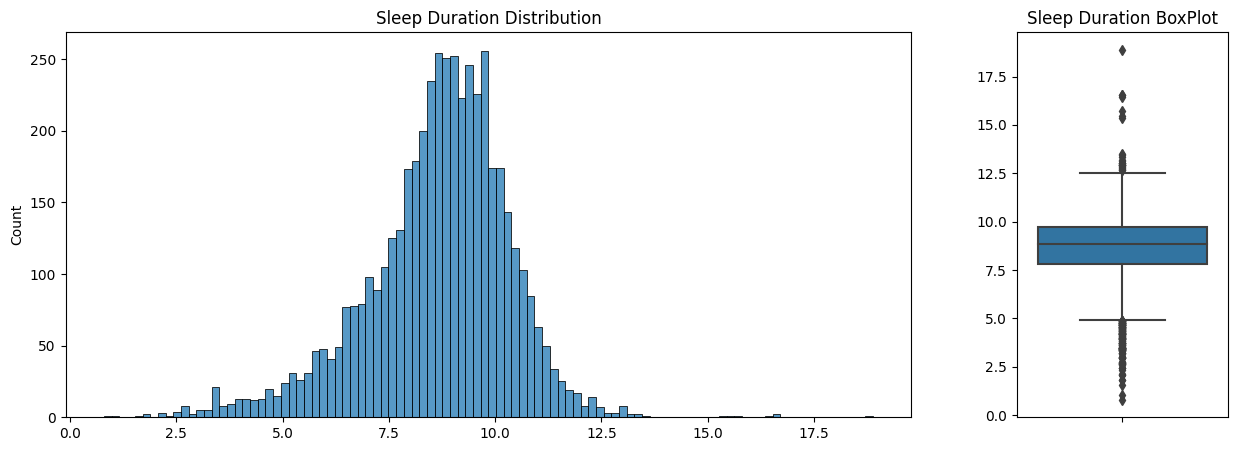

In [28]:
sleep_pairs = list(zip(sleep_events.query("event == 'onset'")['timestamp'], sleep_events.query("event == 'wakeup'")['timestamp']))

sleep_duration = pd.Series(list(map(lambda x: pd.to_timedelta(x[1] - x[0]).total_seconds() / 3600, sleep_pairs)))


fig , axes = plt.subplots(1, 2, width_ratios=[4, 1], figsize = (15, 5))
sns.histplot(x = sleep_duration, bins = 100,
             ax = axes[0])
axes[0].set_title(f'Sleep Duration Distribution')

sns.boxplot(y = sleep_duration, ax = axes[1])
axes[1].set_title(f'Sleep Duration BoxPlot')

## 4-Create Chunked Dataset

## <center> [Dataset Link](https://www.kaggle.com/datasets/adelinmil/chunked-train-series-detect-sleep-states)

In [29]:
# def is_asleep(combined):
#     is_asleep = False
#     for index in combined.index:

#         if combined.loc[index, 'event'] == -1:
#             is_asleep = True
#         elif combined.loc[index, 'event'] == 1:
#             is_asleep = False
#             combined.loc[index, 'event'] = 1

#         if is_asleep:
#             combined.loc[index, 'event'] = 1
    
#     combined.rename(columns = {'event': 'asleep'}, inplace = True)
#     combined['asleep'] = combined['asleep'].astype(np.int8)
    
#     return combined

In [30]:
# def to_parquet(group, event, series_id):
    
#     # convert timestamp column to datetime
#     group['timestamp'] = pd.to_datetime(group['timestamp']).apply(lambda t: t.tz_localize(None))
#     event['timestamp'] = pd.to_datetime(event['timestamp']).apply(lambda t: t.tz_localize(None))
    
#     combined = pd.merge(group, event, on=['series_id', 'timestamp'], how = 'outer')
    
#     combined['event'] = combined['event'].map({np.nan: 0, 'onset': -1, 'wakeup': 1}).astype(np.int8)
# #     combined.rename(columns = {'step_x': 'step'}, inplace = True)
#     combined.drop(['series_id', 'night', 'step_y', 'step_x'], axis = 1, inplace = True)
    
    
#     combined = is_asleep(combined)
    
#     directory = random.choices(['train', 'validation', 'test'], weights = (80,10,10))
#     if directory == ['train']:
#         combined.to_parquet(os.path.join('train',series_id + '.parquet'), index = False)
#     elif directory == ['test']:
#         combined.to_parquet(os.path.join('test',series_id + '.parquet'), index = False)
#     else:
#         combined.to_parquet(os.path.join('validation',series_id + '.parquet'), index = False)

In [31]:
# if not os.path.isdir("train"):
#     os.makedirs("train")
    
# if not os.path.isdir("validation"):
#     os.makedirs("validation")
    
# if not os.path.isdir("test"):
#     os.makedirs("test")

In [32]:
# for s_id in tqdm(series_ids):
    
#     group = ts[ts['series_id'] == s_id]
#     event = sleep_events[sleep_events['series_id'] == s_id]
    
#     to_parquet(group, event, s_id)